# NFL Pass vs Run Prediction Model Notebook

### About this Notebook
(To be added)

### Import Modules

In [1]:
###############################################
############    IMPORTS    ####################
import os
import json
import time
import numpy as np
import pandas as pd
import pandas_profiling

# Plotting Imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerLine2D

# Machine Learning Algorithms
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

### Import Data and Dataframe Properties

In [2]:
# Import Dataframe
# nfl_df = pd.read_csv('../data/play_by_play_2009_2018.csv', low_memory=True)
nfl_df = pd.read_excel('../data/play_by_play_2009_2018_clean.xlsx')

# Print Rows
print("Number of DF Rows: ",len(nfl_df))

# Print Top 3 Rows
nfl_df.head(3)

Number of DF Rows:  449371


,play_type,posteam,posteam_type,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,...,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post
0,kickoff,PIT,home,TEN,30.0,900.0,1800.0,3600.0,Half1,0,...,3.0,3.0,0,0,NaN,NaN,NaN,0.0,0.0,0.0
1,pass,PIT,home,PIT,58.0,893.0,1793.0,3593.0,Half1,0,...,3.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,run,PIT,home,PIT,53.0,856.0,1756.0,3556.0,Half1,0,...,3.0,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Dataframe Exploration & Feature Engineering

##### <u>Profile Data</u>

In [3]:
PROFILE_ANALYSIS = False
if PROFILE_ANALYSIS == True:
    profile = pandas_profiling.ProfileReport(nfl_df, title="NFL Data Pandas Profiling Report", explorative=True, minimal=True)
    profile.to_file("nfl_data_profile_minimal.html")

##### <u>Missing Data</u>

In [4]:
# Use isnull() to Map count of missing values per feature
na_count = nfl_df.isnull().sum()

# Find Total Missing for Na count and NFL Data
total_cells = np.product(nfl_df.shape)
total_missing = na_count.sum()

# Print Percentage of Data that is Missing
print("Percentage of missing values (before play_type filter): % " + str(round((total_missing/total_cells) * 100, 3)))

Percentage of missing values (before play_type filter): % 13.557


##### <u>Create New Features & Filter</u>

In [5]:
# Create Binary Feature for when Possession team is Home (1) or Away (0)
nfl_df['possession_home_away'] = nfl_df.apply(lambda x: 1 if x.posteam_type == "home" else 0, axis=1)

# Create Binary Feature for when Possession team is on Home side of field (1) or Away (0)
nfl_df['possession_home_away_field_side'] = nfl_df.apply(lambda x: 1 if x.posteam != x.side_of_field else 0, axis=1)

# Create Binary Feature for First Half (1) or 2nd Half (0)
nfl_df['game_half_binary'] = nfl_df.apply(lambda x: 1 if x.game_half == "Half1" else 0, axis=1)

# Filter Dataset so that Play_Type == Run or Pass
run_pass_list = ['run', 'pass']
nfl_df = nfl_df[nfl_df['play_type'].isin(run_pass_list)]

# # Create Binary Feature for Pass (1) or Run (0)
nfl_df['play_type'] = nfl_df.apply(lambda x: 1 if x.play_type == "pass" else 0, axis=1)

##### <u>Remove Un-Needed Features</u>

In [6]:
# List of Columns to Remove from Dataset
columns_to_remove = [
    'posteam',	
    'posteam_type',	
    'side_of_field',	
    'game_half',	
    'yrdln',	
    'shotgun',	
    'qb_dropback',	
    'qb_kneel',	
    'qb_spike',	
    'qb_scramble',	
    'pass_length',	
    'pass_location',	
    'air_yards',
    'yards_after_catch',	
    'run_location',	
    'home_timeouts_remaining',	
    'away_timeouts_remaining',	
    'timeout',	
    'timeout_team',	
    'td_team',	
    'posteam_score_post',	
    'defteam_score_post',	
    'score_differential_post']

# Drop List of Columns from Dataset
nfl_df = nfl_df.drop(columns_to_remove, axis = 1)

# Print Dataframe Information
print(nfl_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319369 entries, 1 to 449368
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   play_type                        319369 non-null  int64  
 1   yardline_100                     319369 non-null  float64
 2   quarter_seconds_remaining        319369 non-null  float64
 3   half_seconds_remaining           319352 non-null  float64
 4   game_seconds_remaining           319355 non-null  float64
 5   quarter_end                      319369 non-null  int64  
 6   drive                            319369 non-null  int64  
 7   sp                               319369 non-null  int64  
 8   qtr                              319369 non-null  int64  
 9   down                             318691 non-null  float64
 10  goal_to_go                       319369 non-null  float64
 11  ydstogo                          319369 non-null  int64  
 12  no

In [7]:
# Use isnull() to Map count of missing values per feature
na_count = nfl_df.isnull().sum()

# Find Total Missing for Na count and NFL Data
total_cells = np.product(nfl_df.shape)
total_missing = na_count.sum()

# Print Percentage of Data that is Missing
print("Percentage of missing values (post play_type filter): % " + str(round((total_missing/total_cells) * 100, 3)))

# Print Rows
print("Number of DF Rows: ",len(nfl_df))

Percentage of missing values (post play_type filter): % 0.01
Number of DF Rows:  319369


##### <u>Scale Numerical Data (0, 1)</u>

In [8]:
# Set Data to All Values of NFL Data
scaled_data = nfl_df.values[:, :]

# Perform a robust scaler transform of the dataset
trans = MinMaxScaler()
scaled_data = trans.fit_transform(scaled_data)

# Set our Column Names
column_name_nfl = nfl_df.columns.values.tolist()

# Convert the scaled array back to our NFL Dataframe
nfl_df = pd.DataFrame(scaled_data, columns = column_name_nfl)
nfl_df

,play_type,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,...,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,possession_home_away,possession_home_away_field_side,game_half_binary
0,1.0,0.581633,0.992222,0.996111,0.998056,0.0,0.000000,0.0,0.00,0.000000,...,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.0,0.0,1.0
1,0.0,0.530612,0.951111,0.975556,0.987778,0.0,0.000000,0.0,0.00,0.333333,...,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.0,0.0,1.0
2,1.0,0.561224,0.905556,0.952778,0.976389,0.0,0.000000,0.0,0.00,0.666667,...,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.0,0.0,1.0
3,0.0,0.989796,0.884444,0.942222,0.971111,0.0,0.027027,0.0,0.00,0.000000,...,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.0,1.0
4,1.0,0.989796,0.844444,0.922222,0.961111,0.0,0.027027,0.0,0.00,0.333333,...,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319364,1.0,0.714286,0.091111,0.045556,0.022778,0.0,0.513514,0.0,0.75,0.333333,...,0.0,0.333333,0.114754,0.206897,0.114754,0.196721,0.457627,1.0,0.0,0.0
319365,1.0,0.714286,0.085556,0.042778,0.021389,0.0,0.513514,0.0,0.75,0.666667,...,0.0,0.333333,0.114754,0.206897,0.114754,0.196721,0.457627,1.0,0.0,0.0
319366,1.0,0.663265,0.070000,0.035000,0.017500,0.0,0.513514,0.0,0.75,0.333333,...,0.0,0.333333,0.114754,0.206897,0.114754,0.196721,0.457627,1.0,0.0,0.0
319367,1.0,0.663265,0.064444,0.032222,0.016111,0.0,0.513514,0.0,0.75,0.666667,...,0.0,0.333333,0.114754,0.206897,0.114754,0.196721,0.457627,1.0,0.0,0.0


##### <u>Univariate Selection</u>

In [9]:
nfl_df = nfl_df.fillna(0)

# X is Equal to All our our Predictor Variables (Independent Columns)
predictor_x = nfl_df.loc[:, nfl_df.columns != 'play_type']

# Set Y Equal to our Target Play_Type Column Index Location
target_y = nfl_df.iloc[:, 0]

# Use SKLearn's SelectKBest to Extract the Top 10 Best Features
select_k_best_features = SelectKBest(score_func=chi2, k=20)
fit = select_k_best_features.fit(predictor_x, target_y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(predictor_x.columns)

# Concatenate the Scores and the Columns Names to get our Response DataFrame
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Specs','Score'] 
print(feature_scores.nlargest(20,'Score'))

                              Specs        Score
8                              down  4139.819086
11                        no_huddle  1159.371058
17                    defteam_score   700.030113
2            half_seconds_remaining   521.711513
9                        goal_to_go   463.671326
6                                sp   389.329245
1         quarter_seconds_remaining   363.293883
12       posteam_timeouts_remaining   198.859648
18               score_differential   148.146737
16                    posteam_score   147.760300
3            game_seconds_remaining   145.454573
10                          ydstogo    89.465783
20  possession_home_away_field_side    81.885519
15                 total_away_score    74.523221
14                 total_home_score    64.460651
7                               qtr    64.053140
5                             drive    58.580240
13       defteam_timeouts_remaining    28.642363
0                      yardline_100    24.618106
19             posse

##### <u>Feature Importance</u>

[0.10889962 0.10075729 0.10351371 0.10030902 0.         0.07338409
 0.004762   0.00806099 0.07618722 0.00433321 0.08160324 0.00756826
 0.02566115 0.02792722 0.04347681 0.04243767 0.04698631 0.05012845
 0.06597609 0.01516545 0.0097186  0.00314359]


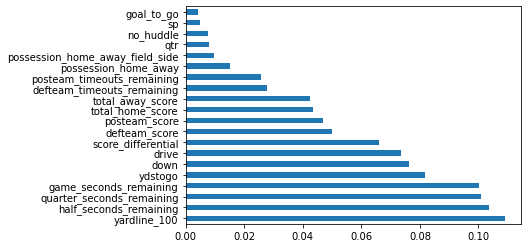

In [10]:
# X is Equal to All our our Predictor Variables (Independent Columns)
predictor_x = nfl_df.loc[:, nfl_df.columns != 'play_type']

# Set Y Equal to our Target Play_Type Column Index Location
target_y = nfl_df.iloc[:, 0]

model = ExtraTreesClassifier()
model.fit(predictor_x, target_y)
print(model.feature_importances_)

# Plot graph of feature importance
feat_importances = pd.Series(model.feature_importances_, index=predictor_x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

##### <u>Correlation Matrix with Heatmap</u>

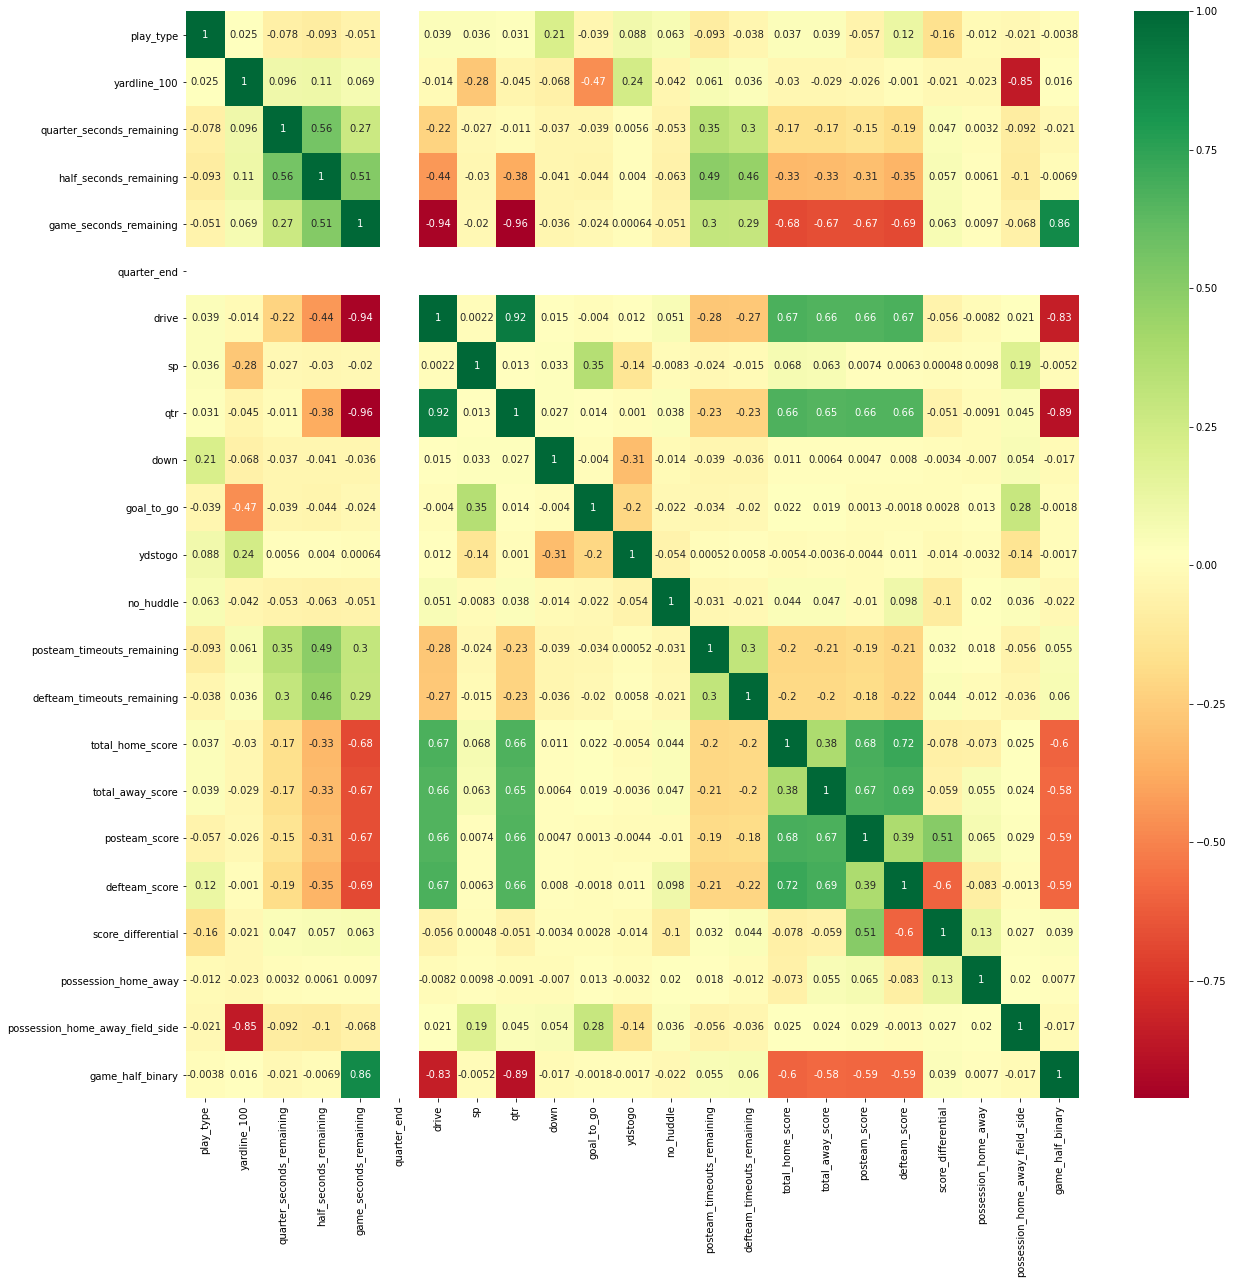

In [11]:
corrmat = nfl_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Plot heat map
g=sns.heatmap(nfl_df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

### Feature Selection

##### <u>Create X and Y Dataframes</u>

In [12]:
# Define our prediction data
plays_predictors = ['down',
                    'no_huddle',
                    'defteam_score',
                    'half_seconds_remaining',
                    'goal_to_go',
                    'sp',
                    'quarter_seconds_remaining',
                    'posteam_timeouts_remaining',
                    'score_differential',
                    'posteam_score',
                    'game_seconds_remaining',
                    'ydstogo',
                    'possession_home_away_field_side']

predictor_x = nfl_df[plays_predictors]

# Define the prediction target: PlayType
target_y = nfl_df.play_type

##### <u>Split into Test and Train Dataframes</u>

In [13]:
# Split our data into training and test data for both our target and prediction data sets
train_X, test_X, train_y, test_y = train_test_split(predictor_x, target_y, random_state = 0)

### Model Testing

##### <u>Random Forest Model</u>

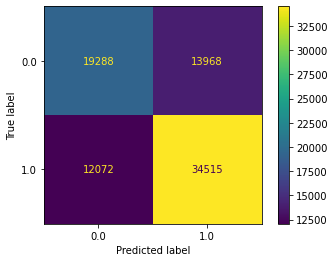

In [14]:
# Initialize Model
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X, train_y)

# Predict on Testing X Dataframe
random_forest_predictions = random_forest.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, random_forest_predictions)
random_forest_roc_auc = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(random_forest, test_X, test_y)  
plt.show()  

##### <u>Decision Tree Model</u>

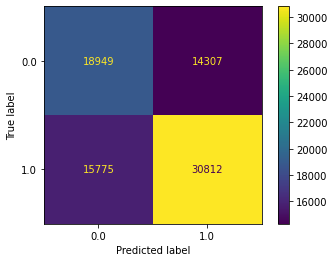

In [15]:
# Initialize Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X, train_y)

# Predict on Testing X Dataframe
decision_tree_predictions = decision_tree.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, decision_tree_predictions)
decision_tree_roc_auc = auc(false_positive_rate, true_positive_rate)

# Calculate Sklearn Metric Accuracy Score
plot_confusion_matrix(decision_tree, test_X, test_y)  
plt.show() 

##### <u>K-Nearest Neighbor Model</u>

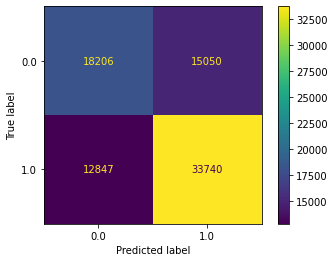

In [16]:
# Initialize Model
k_nearest_neighbors = KNeighborsClassifier(n_neighbors = 5)
k_nearest_neighbors.fit(train_X, train_y)

# Predict on Testing X Dataframe
k_nearest_neighbors_predictions = k_nearest_neighbors.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, k_nearest_neighbors_predictions)
k_nearest_neighbor_roc_auc = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(k_nearest_neighbors, test_X, test_y)  
plt.show() 

##### <u>Gradient Boosting Model</u>

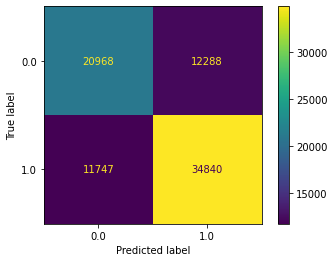

In [17]:
# Initialize Model
gradient_boosting_model = GradientBoostingClassifier()
gradient_boosting_model.fit(train_X, train_y)

# Predict on Testing X Dataframe
gradient_boosting_predictions = gradient_boosting_model.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, gradient_boosting_predictions)
gradient_boosting_roc_auc = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(gradient_boosting_model, test_X, test_y)  
plt.show() 

##### <u>Gaussian Naive Bayes Model</u>

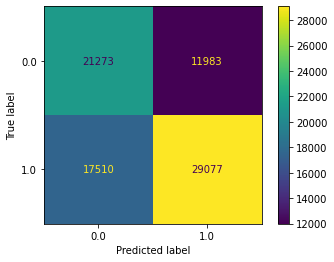

In [18]:
# Gaussian Naive Bayes
gaussian_naive_bayes = GaussianNB()
gaussian_naive_bayes.fit(train_X, train_y)

# Predict on Testing X Dataframe
gaussian_naive_bayes_predictions = gaussian_naive_bayes.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, gaussian_naive_bayes_predictions)
gaussian_naive_bayes_roc_auc = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(gaussian_naive_bayes, test_X, test_y)  
plt.show() 

##### <u>Support Vector Machine</u>

In [20]:
# ADD CODE HERE
print("Building & Training SVM Model")
svm_clf = SVC(decision_function_shape='ovo')
svm_clf.fit(train_X, train_y)

# Predict on Testing X Dataframe
print("Creating Predictions")
svm_predictions = svm_clf.predict(test_X)

# Calculate False and True Positieves with Predictions and True Value
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, svm_predictions)
svm_roc_auc = auc(false_positive_rate, true_positive_rate)

Building & Training SVM Model
Creating Predictions


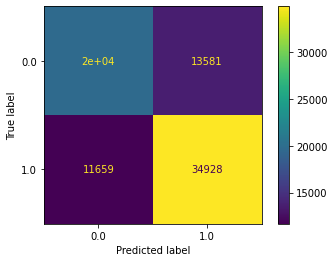

In [24]:
plot_confusion_matrix(svm_clf, test_X, test_y)  
plt.show() 

##### <u>Score Models with Jaccard Score</u>

In [25]:
random_forest_accuracy_score = accuracy_score(test_y, random_forest_predictions)
decision_tree_accuracy_score = accuracy_score(test_y, decision_tree_predictions)
k_nearest_neighbors_accuracy_score = accuracy_score(test_y, k_nearest_neighbors_predictions)
gradient_boosting_accuracy_score = accuracy_score(test_y, gradient_boosting_predictions)
gaussian_naive_bayes_accuracy_score = accuracy_score(test_y, gaussian_naive_bayes_predictions)
svm_accuracy_score = accuracy_score(test_y, svm_predictions)

### Model Validation

##### <u>AUC Score Output</u>

In [26]:
# Create Dataframe of our Scores
auc_model_scores = pd.DataFrame({
    'Model': ['Decision Tree', 
              'Random Forest', 
              'KNN',
              'Naive Bayes', 
              'Gradient Boosting Classifier',
              'Support Vector Machine'],
    'AUC': [decision_tree_roc_auc, 
            random_forest_roc_auc, 
            k_nearest_neighbor_roc_auc, 
            gaussian_naive_bayes_roc_auc, 
            gradient_boosting_roc_auc,
            svm_roc_auc]})

# Create Output Dataframe Sorted & Re-Indexed
auc_model_scores_df = auc_model_scores.sort_values(by='AUC', ascending=False)
auc_model_scores_df = auc_model_scores_df.set_index('AUC')
auc_model_scores_df

,Model
AUC,
0.689175,Gradient Boosting Classifier
0.670680,Support Vector Machine
0.660429,Random Forest
0.635843,KNN
0.631909,Naive Bayes
0.615589,Decision Tree


##### <u>Jaccard Accuracy Score Output</u>

###### <i> The Jaccard index [1], or Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true. </i>

In [27]:
# Create Dataframe of our Scores
jaccard_accuracy = pd.DataFrame({
    'Model': ['Random Forest', 
              'Decision Tree', 
              'KNN',
              'Gradient Boosting Classifies', 
              'Naive Bayes',
              'Support Vector Machine'],
    'Accuracy': [random_forest_accuracy_score, 
            decision_tree_accuracy_score, 
            k_nearest_neighbors_accuracy_score, 
            gradient_boosting_accuracy_score, 
            gaussian_naive_bayes_accuracy_score,  
            svm_accuracy_score
           ]})

# Create Output Dataframe Sorted & Re-Indexed
jaccard_accuracy_df = jaccard_accuracy.sort_values(by='Accuracy', ascending=False)
jaccard_accuracy_df = jaccard_accuracy_df.set_index('Accuracy')
jaccard_accuracy_df

,Model
Accuracy,
0.698972,Gradient Boosting Classifies
0.683880,Support Vector Machine
0.673860,Random Forest
0.650602,KNN
0.630613,Naive Bayes
0.623236,Decision Tree


In [28]:
os.getcwd()

'C:\\Users\\kstobbe\\OneDrive - Sunpower Corporation\\Desktop\\Georgia Tech\\team_project\\backend_src\\notebooks'

In [71]:
import joblib

col_names = ['down',
            'no_huddle',
            'goal_to_go',
            'sp',
            'defteam_score',
            'half_seconds_remaining',
            'quarter_seconds_remaining',
            'posteam_timeouts_remaining',
            'score_differential',
            'posteam_score',
            'game_seconds_remaining',
            'ydstogo']

# Test Data
data = [[3,1,1,20,5,100,100,3,10,40,100,20]]
data_frame = pd.DataFrame(data, columns = col_names)
data_frame

# Enconder
encoder = joblib.load('./joblibs/encoder.joblib') 
X_enc = encoder.transform(data_frame[data_frame.columns[0:2]])
X_enc = X_enc.toarray()

# Concatenate
data_frame = np.array(data_frame[[col for col in data_frame.columns if col not in data_frame.columns[0:2]]])
X_p = np.concatenate([data_frame,X_enc[:,2::]],axis=1)
X_p[np.where(np.isnan(X_p))] = 0

# Test Model
filename = './joblibs/knn.joblib'
loaded_model = joblib.load(filename)
prediction = loaded_model.predict(X_p)
int(prediction[0])

C:\Users\kstobbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\kstobbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1